In [1]:
import numpy as np
import cv2
import os
import PIL 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers ,models
import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import Image
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def add_gaussian_noise(image, mean=0, stddev=25):
    noise = np.random.normal(mean, stddev, image.shape).astype('uint8')
    noisy_image = np.clip(image + noise, 0, 255)
    return noisy_image

def apply_gaussian_filter(image, sigma=1):
    filtered_image = gaussian_filter(image, sigma=sigma)
    return filtered_image

def apply_gaussian_filter_with_noise(image_path, noise_mean, noise_stddev, sigma):
    # Load the image using PIL
    image = cv2.imread(image_path)
#     image = image.reshape(-1,3044,/ 4048, 3)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = image.reshape(-1,64,64,3)
    
    # Add Gaussian noise
    noisy_image = add_gaussian_noise(image, noise_mean, noise_stddev)

    # Apply Gaussian filter
    filtered_image = apply_gaussian_filter(noisy_image, sigma)

    return image,noisy_image, filtered_image

# Example usage
# image_path = 'img.jpeg'
# noise_mean = 0  # Mean of Gaussian noise
# noise_stddev = 25  # Standard deviation of Gaussian noise
# sigma = 1  # Sigma for the Gaussian filter

# image,noisy_image, filtered_image = apply_gaussian_filter_with_noise(image_path, noise_mean, noise_stddev, sigma)

In [3]:
def create_data(file_path):
    x = []
    y = []
    
    for i in os.listdir(file_path):
        n=0
        for j in os.listdir(file_path+'//'+i):
            if n<80:
                noise_mean = 0  # Mean of Gaussian noise
                noise_stddev = 1  # Standard deviation of Gaussian noise
                sigma = 1  # Sigma for the Gaussian filter
                image_path = file_path+'//'+i+'//'+j 
                image,noisy_image, filtered_image = apply_gaussian_filter_with_noise(image_path, noise_mean, noise_stddev, sigma)
                x.append(filtered_image)
                y.append(image)
                n+=1
            else:
                break
    return np.array(x),np.array(y)

In [4]:
file_path = '/kaggle/input/flowers-recognition/flowers'
x,y = create_data(file_path)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the DnCNN model
def dncnn_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    
    # Stack of residual blocks
    for _ in range(15):
        residual = tf.keras.layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.Activation('relu')(x)
    
    # Final convolutional layer
    outputs = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Create the DnCNN model
input_shape = (224, 224, 1)  # Adjust the input shape to match your data
model = dncnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36864       ['conv2d[0][0]']                 
                                )                                                             

In [6]:
input_shape = (224, 224, 1)  # Adjust the input shape to match your data
model = dncnn_model(input_shape)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
batch_size = 32
epochs = 100

model.fit(x,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/100
10/10 [==============================] - 19s 811ms/step - loss: 269176.6875 - val_loss: 691.8065
Epoch 2/100
10/10 [==============================] - 7s 699ms/step - loss: 1166.9065 - val_loss: 803.1769
Epoch 3/100
10/10 [==============================] - 7s 699ms/step - loss: 649.0215 - val_loss: 530.6826
Epoch 4/100
10/10 [==============================] - 7s 699ms/step - loss: 479.6617 - val_loss: 369.1649
Epoch 5/100
10/10 [==============================] - 7s 716ms/step - loss: 384.4992 - val_loss: 296.0077
Epoch 6/100
10/10 [==============================] - 7s 700ms/step - loss: 305.6516 - val_loss: 221.3497
Epoch 7/100
10/10 [==============================] - 7s 699ms/step - loss: 240.5915 - val_loss: 176.9477
Epoch 8/100
10/10 [==============================] - 7s 700ms/step - loss: 226.2023 - val_loss: 171.3413
Epoch 9/100
10/10 [==============================] - 7s 699ms/step - loss: 220.4361 - val_loss: 206.2933
Epoch 10/100
10/10 [==============================

1/1 [==============================] - 0s 238ms/step
(1, 224, 224, 1)
σ-1


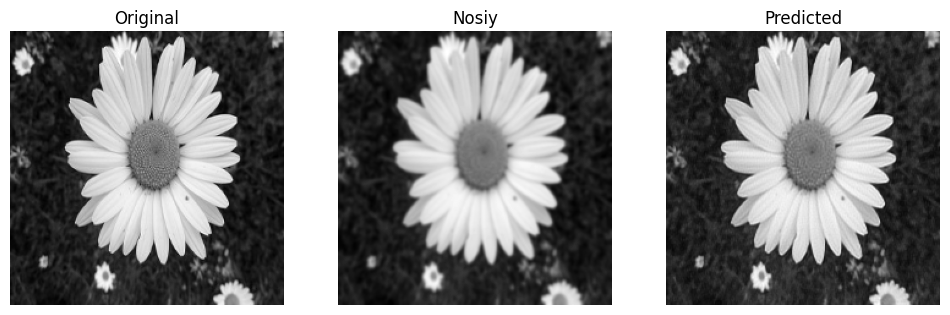

In [7]:
i=110
pred = x[i]
original = y[i]
pred = pred.reshape(-1,224,224,1)
img = model.predict(pred)
print(img.shape)
img = img.reshape(224,224,1)
# plt.imshow(x[20])
plt.figure(figsize=(12, 6))
print('σ-1')
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(y[i],cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Nosiy')
plt.imshow(x[i],cmap='gray')
plt.axis('off')
# test = x[i] - img
plt.subplot(1, 3, 3)
plt.title('Predicted')
plt.imshow(img,cmap='gray')
plt.axis('off')

plt.show()

In [8]:
model.save("3rd.h5")

In [9]:
import numpy as np
import math
from skimage.metrics import structural_similarity as compare_ssim

def psnr(original, noisy):
    # Ensure both images have the same shape
    if original.shape != noisy.shape:
        raise ValueError("Both images must have the same dimensions.")

    # Calculate the mean squared error (MSE)
    mse = np.mean((original - noisy) ** 2)

    # Calculate the maximum possible pixel value (assumed to be 255 for 8-bit images)
    max_pixel_value = 255.0

    # Calculate PSNR
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))

    return psnr




In [10]:
import tensorflow as tf

def custom_mse_loss(y_true, y_pred):
    # Calculate the mean squared error
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse


In [11]:
original = original.reshape(224,224,1)
psnr_value = psnr(original, img)
print(f"PSNR: {psnr_value} dB")
original_2 = original.reshape(224,224)
img_2 = img.reshape(224,224)
ssim_value = compare_ssim(original_2, img_2,data_range=img.max() - img.min())
print(f"SSIM: {ssim_value} dB")
mse = custom_mse_loss(original, img)
print(f"MSE: {mse}")

PSNR: 32.356653634085106 dB
SSIM: 0.9527748833873193 dB
MSE: 37.79331970214844


In [12]:
original = original.reshape(224,224,1)

In [13]:
psnr(original, img)

32.356653634085106

In [14]:
original_2 = original.reshape(224,224)
img_2 = img.reshape(224,224)
compare_ssim(original, img,data_range=img.max() - img.min())

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [ ]:

from skimage import io

def compute_ssim(image_path1, image_path2, win_size=7):
    try:
        img1 = io.imread(image_path1)
        img2 = io.imread(image_path2)

        if img1.shape != img2.shape:
            raise ValueError("Images must have the same dimensions for SSIM calculation.")

        # Ensure that win_size is an odd value less than or equal to the smaller side of the images
        win_size = min(win_size, min(img1.shape[0], img1.shape[1]))
        if win_size % 2 == 0:
            win_size += 1

        ssim = compare_ssim(img1, img2, multichannel=True, win_size=win_size)
        return ssim

    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage:
# image_path1 = 'image1.jpg'  # Replace with the path to your first image
# image_path2 = 'image2.jpg'  # Replace with the path to your second image

ssim_value = compute_ssim(original, img, win_size=7)

if ssim_value is not None:
    print(f"SSIM with win_size=7: {ssim_value}")


In [ ]:
calculate_ssim(change_dtype_to_float32(original), img)